In [34]:
#library

import tarfile
import os
import shutil

import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

import torch
from torch import nn,optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models

from sklearn.model_selection import train_test_split

In [4]:
#test network

def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True

In [5]:
#show image

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [6]:
#download image

!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

--2023-07-05 17:57:24--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  42.7MB/s    in 19s     

2023-07-05 17:57:44 (39.1 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [8]:
#다운받은 이미지 데이터를 Images 폴더에 압축을 푼다

TARGET_PATH = "Images"

if os.path.exists(TARGET_PATH):

    shutil.rmtree(TARGET_PATH)

fname = "images.tar"
tar = tarfile.open(fname, "r:tar")
tar.extractall()
tar.close()

In [9]:
#120종류의 강아지
len(os.listdir(TARGET_PATH))

120

In [10]:
#데이터가 이상한 이름이라 이름을 바꿈

for dir_name in os.listdir(TARGET_PATH):

    breed_name = dir_name.split("-")[-1].lower()
    source_dir = os.path.join(TARGET_PATH, dir_name)
    target_dir = os.path.join(TARGET_PATH, breed_name)

    shutil.move(source_dir, target_dir)

In [11]:
dataset = []

#https://ponyozzang.tistory.com/545
#glob.iglob: 해당 경로의 모든 하위 경로에서 jpg 파일을 모두 검색해 iterator로 취득
for filepath in glob.iglob(f'{TARGET_PATH}/**/*.jpg', recursive = True):

    breed_name = filepath.split("/")[1]
    dataset.append([filepath, breed_name])

dataset = np.array(dataset)


In [12]:
dataset

array([['Images/gordon_setter/n02101006_1435.jpg', 'gordon_setter'],
       ['Images/gordon_setter/n02101006_751.jpg', 'gordon_setter'],
       ['Images/gordon_setter/n02101006_6342.jpg', 'gordon_setter'],
       ...,
       ['Images/malamute/n02110063_18180.jpg', 'malamute'],
       ['Images/malamute/n02110063_12326.jpg', 'malamute'],
       ['Images/malamute/n02110063_17622.jpg', 'malamute']], dtype='<U75')

In [14]:
dataset[:,0] #data

array(['Images/gordon_setter/n02101006_1435.jpg',
       'Images/gordon_setter/n02101006_751.jpg',
       'Images/gordon_setter/n02101006_6342.jpg', ...,
       'Images/malamute/n02110063_18180.jpg',
       'Images/malamute/n02110063_12326.jpg',
       'Images/malamute/n02110063_17622.jpg'], dtype='<U75')

In [15]:
dataset[:,1] #label

array(['gordon_setter', 'gordon_setter', 'gordon_setter', ..., 'malamute',
       'malamute', 'malamute'], dtype='<U75')

In [16]:
#split dataset

#stratify split by class

train_image, test_image, train_target, test_target = train_test_split(dataset[:,0], dataset[:,1], stratify = dataset[:,1])

In [17]:
train_image.shape, test_image.shape

((15435,), (5145,))

In [19]:
#stratify하게 추출했다면, train과 test의 비율이 비슷함

pd.Series(train_target).value_counts() / len(train_target)

coated_retriever      0.014707
maltese_dog           0.012245
afghan_hound          0.011597
scottish_deerhound    0.011273
samoyed               0.010625
                        ...   
pekinese              0.007256
affenpinscher         0.007256
malinois              0.007256
clumber               0.007256
redbone               0.007191
Length: 119, dtype: float64

In [20]:
pd.Series(test_target).value_counts() / len(test_target)

coated_retriever       0.014772
maltese_dog            0.012245
afghan_hound           0.011662
scottish_deerhound     0.011273
pomeranian             0.010690
                         ...   
redbone                0.007191
dhole                  0.007191
eskimo_dog             0.007191
irish_water_spaniel    0.007191
groenendael            0.007191
Length: 119, dtype: float64

In [21]:
#train과 test를 폴더별로 만든 dataset 폴더 생성

DATA_PATH = 'dataset'

if not os.path.exists(DATA_PATH):

    os.mkdir(DATA_PATH)
    os.makedirs(os.path.join(DATA_PATH, 'train'))
    os.makedirs(os.path.join(DATA_PATH, 'test'))

    for breed_name in set(test_target):

        os.makedirs(os.path.join(DATA_PATH, 'train', breed_name))
        os.makedirs(os.path.join(DATA_PATH, 'test', breed_name))

In [23]:
#train, test의 이미지 파일을 생성한 train,test 폴더에 복사함

for filepath, target_dir in zip(train_image.tolist(), train_target.tolist()):

    filename = filepath.split("/")[-1]
    source_path = filepath
    target_dir = os.path.join(DATA_PATH, 'train', target_dir, filename)
    shutil.copy(source_path, target_dir)

for filepath, target_dir in zip(test_image.tolist(), test_target.tolist()):

    filename = filepath.split("/")[-1]
    source_path = filepath
    target_dir = os.path.join(DATA_PATH, 'test', target_dir,filename)
    shutil.copy(source_path, target_dir)


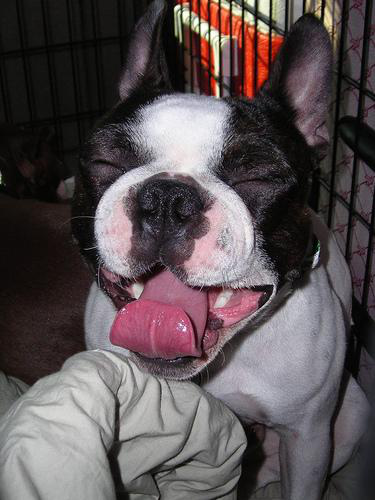

In [26]:
#open image

im = Image.open(target_dir)
im

In [28]:
def process(filename: str=None) -> None:

    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """

    image = mpimg.imread(filename)

    plt.figure()
    plt.imshow(image)

['brabancon_griffon' 'australian_terrier' 'saluki' 'cocker_spaniel'
 'miniature_schnauzer' 'borzoi' 'sealyham_terrier' 'english_setter'
 'sealyham_terrier' 'japanese_spaniel']


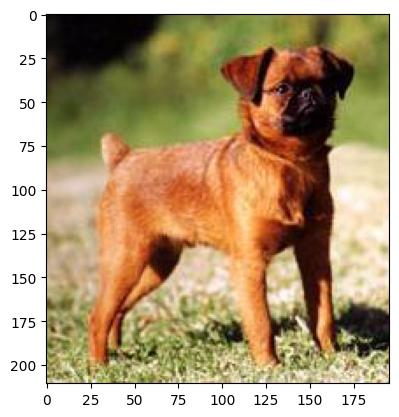

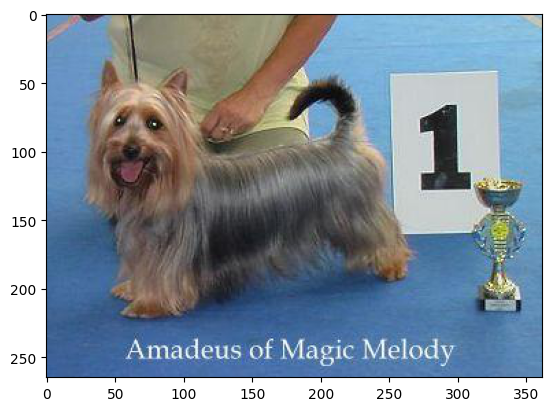

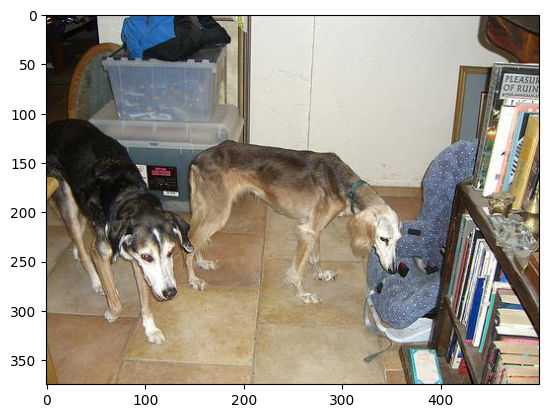

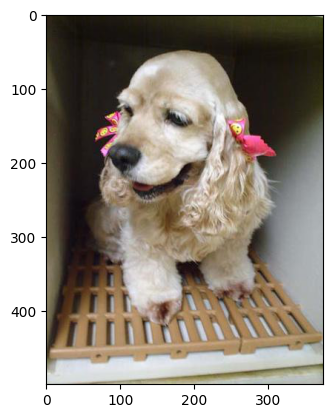

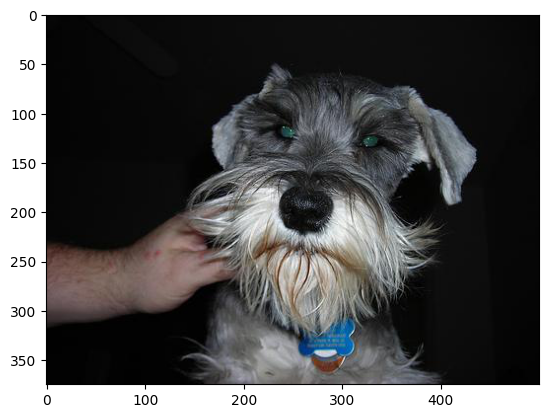

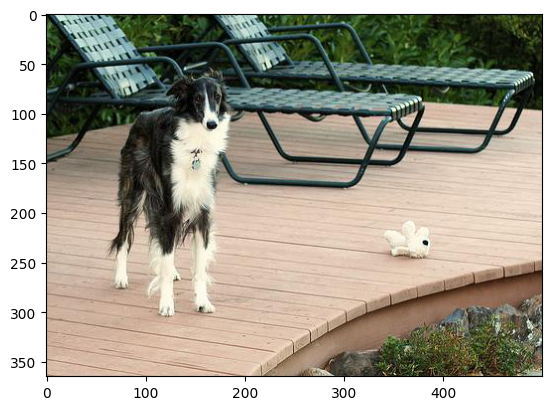

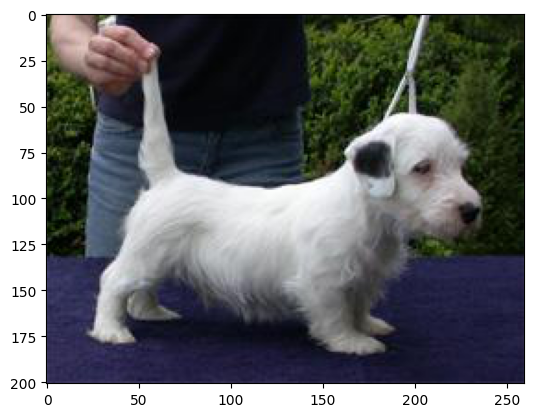

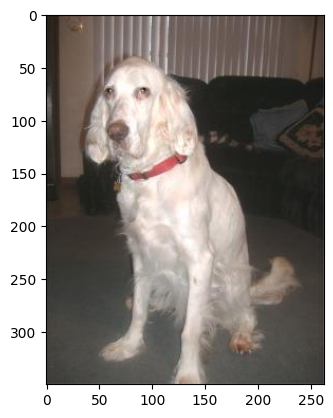

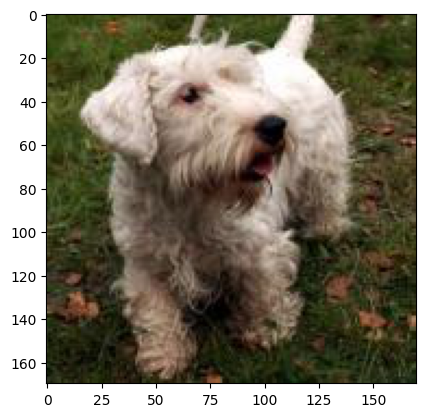

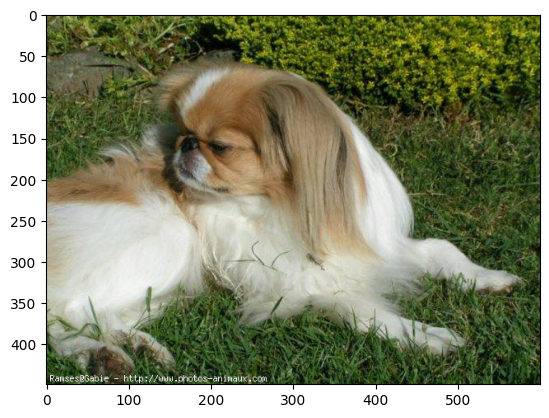

In [29]:
idx = np.random.choice(len(dataset), 10)

images = dataset[:, 0][idx]

for file in images:

    process(file)

print(dataset[:,1][idx])

In [32]:
#define transform

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [33]:
#transform data

DATASET_PATH = 'dataset'

train_data = datasets.ImageFolder(DATASET_PATH + '/train', transform = train_transforms)
test_data = datasets.ImageFolder(DATASET_PATH + '/test', transform = test_transforms)

In [35]:
#dataloader
#test는 셔플 안하는데 보통... 여기는 왜 했는지 모르겠지만 일단 되어있네

train_loader = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 32, shuffle = True)

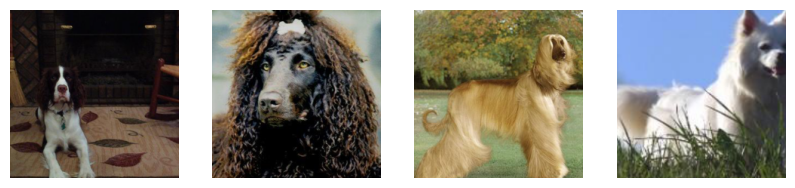

In [36]:
#배치사이즈만큼의 사진을 불러온다

data_iter = iter(test_loader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize = (10,4), ncols = 4)

for ii in range(4):

    ax = axes[ii]

    imshow(images[ii], ax = ax, normalize = True)